In [1]:
#Librería de graficación
import matplotlib.pyplot as plt
import matplotlib as mp
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import metpy.calc as mpcalc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gsa
import matplotlib.ticker as mticker
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot, transforms



#Librerías de procesamiento matemático y lectura de archivos
import numpy as np
import netCDF4 as nc
import pandas as pd
import glob
import os
from scipy import signal

#Librería de estadística
import scipy as sp
from scipy.stats import pearsonr,spearmanr

#librería para manejo de fechas
from datetime import datetime,timedelta

plt.style.use("seaborn")
mp.rcParams['xtick.labelsize']=15
mp.rcParams['ytick.labelsize']=15

mp.rcParams['axes.labelsize']=17

In [2]:
def reading_netcdf(ruta):
    data=nc.Dataset(ruta)
    for i in data.variables:
        try:
            print (i,data.variables[i].shape,data.variables[i].units) 
        except:
            print (i,data.variables[i].shape) 
    print("\n")
    data_variables=[np.array(data[i][:]) for i in list(data.variables.keys())]
    return data_variables

In [3]:
rutas = np.sort(glob.glob("/Users/Mateo/Desktop/Estudio/Universidad/Semestre_10/Analisis_de_Datos_Ambientales/Tarea_2/CMEMS_ECMFW/*.nc"))

#Al estar por años se debe concatenar
for i in range(0,len(rutas)):
    if i==0:
        [adt,time,lat,lon,ugos,vgos,vgosa,sla,ugosa]=reading_netcdf(rutas[i])
    else:
        [adt,time2,lat,lon,ugos,vgos,vgosa,sla2,ugosa]=reading_netcdf(rutas[i])
        sla=np.concatenate((sla,sla2))
        time=np.concatenate((time,time2))

adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (367, 45, 185) m
time (367,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (367, 45, 185) m/s
vgos (367, 45, 185) m/s
vgosa (367, 45, 185) m/s
sla (367, 45, 185) m
ugosa (367, 45, 185) m/s


adt (366, 45, 185) m
tim

Resolución diaria

In [4]:
sla[sla<=-1000]=np.nan     # Asignamos nan a los valores en tierra.
da=[datetime(1950,1,1,0,0,0)+timedelta(days=int(time[w])) for w in range (0,len(time))]     # Asignamos fechas a la linea de tiempo.
date=pd.DatetimeIndex(da)
new_array = np.array(date.to_pydatetime(), dtype=object)
sla_copy=sla

## Análisis de Fourier

In [5]:
A=np.reshape(sla_copy,(len(time),len(lon)*len(lat)))     # Se crea la matrix A.
fila1_A = np.array(A[0,:])
pos_cont = np.isnan(fila1_A)     #Se hallan los índices de las posiciones que son tierra (nan).
pos_mar  = (np.where(pos_cont == False))[0]
A_no_land = A[:, pos_mar]     #Se seleccionan solo las posiciones asociadas al mar.

In [6]:
A_no_land.shape

(9289, 7444)

In [19]:
freq_sla   = np.fft.fftfreq(np.shape(A_no_land)[0])
A_no_land_filt  = np.ones((np.shape(A_no_land)[0], np.shape(A_no_land)[1])) * np.nan
for col in range(np.shape(A_no_land)[1]):
    fft_slai = np.fft.fft(A_no_land[:, col])
    fft_sla_filt = np.copy(fft_slai)
    fft_sla_filt[np.where((np.abs(1/freq_sla)>(365*6)) | (np.abs(1/freq_sla)<((365*2))))]=0
    sla_band = np.fft.ifft(fft_sla_filt)
    A_no_land_filt[:, col] = sla_band

C:\Users\Mateo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\Mateo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


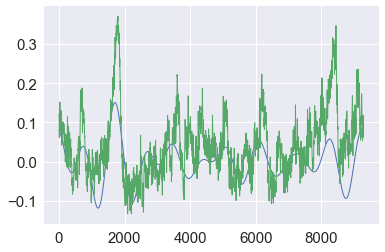

In [20]:
# Verificamos si los resultados obtenidos tienen sentido
plt.plot(A_no_land_filt[:, 0], linewidth=1.0)
plt.plot(A_no_land[:, 0], linewidth=1.0)
plt.show()

## Funciones Ortogonales Empíricas

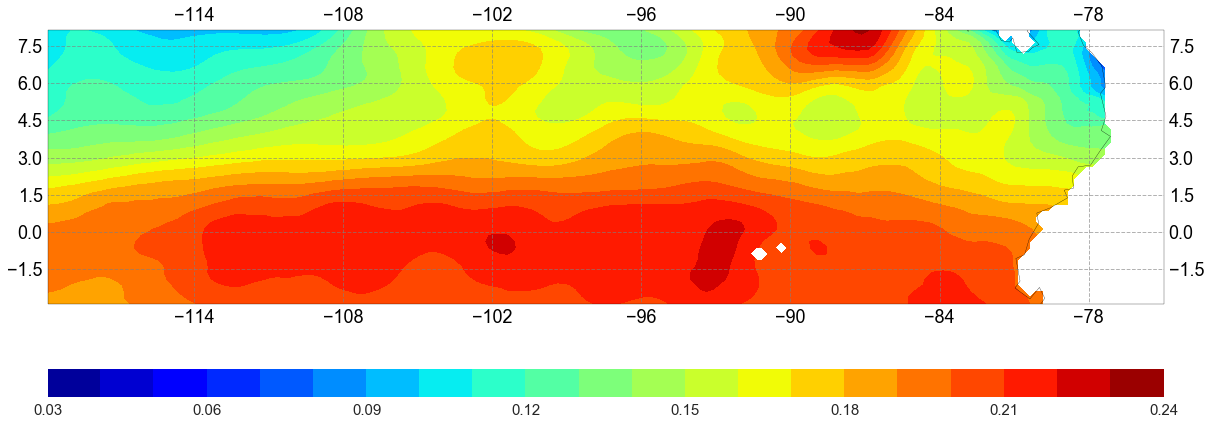

In [39]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,sla_copy[2000,:,:],20,transform=ccrs.PlateCarree(),cmap="jet")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.coastlines()
cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

## Haciendo la EOF

In [21]:
U,S,Vh=np.linalg.svd(A_no_land_filt)

In [22]:
U.shape,S.shape,Vh.shape

((9289, 9289), (7444,), (7444, 7444))

### Modos de oscilación

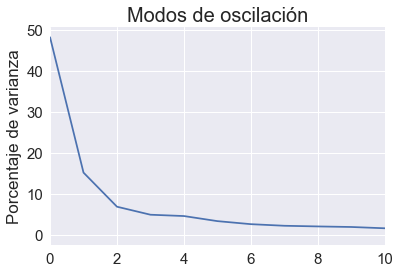

In [23]:
fig = plt.figure()
plt.plot((S/np.sum(S))*100)
plt.xlim(0,10)
plt.title("Modos de oscilación", fontsize=20)
plt.ylabel("Porcentaje de varianza")
fig.savefig("Graficos\EOF_Var.jpg",dpi=100,bbox_inches='tight')

(9289, 9289)

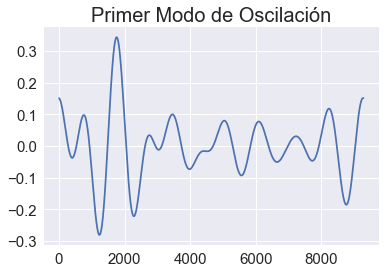

In [25]:
fig = plt.figure()
plt.plot(U[:,0]*(-10))
plt.title('Primer Modo de Oscilación', fontsize=20)
fig.savefig("Graficos\EOF_PMO.jpg",dpi=100,bbox_inches='tight')
U.shape
# plt.plot(sla[:,:,:])

In [ ]:
dataset_oni=pd.read_excel(r"/home/franklin/Documentos/GitHub/TDG/Dataset/oni index.xlsx").set_index("Year")
data=dataset_oni.values.ravel()
fechas=pd.date_range("1950-01-01","2019-01-01",freq="M")
date_oni=[i-timedelta(days=15) for i in fechas]
serie_oni_d=pd.Series(data=data,index=date_oni)

fig,ax=plt.subplots(1,1)
ax.plot(date[12:],(U[:,0]*-10))*10,c='k')
ax2 = ax.twinx()
ax2.plot(serie_oni_d.rolling(12).mean()[365:],c='red',alpha=0.5,label="ONI")
ax2.tick_params(axis='y', labelcolor='red')
ax.set_xlim(date[12],date[-1])

### Pintando la EOF

In [26]:
verify=np.copy(fila1_A)

In [27]:
iters=0
for i in range(len(verify)):
    if np.isnan(verify[i])==True:
        iters=iters
    if np.isnan(verify[i])==False:
        verify[i]==Vh[0,iters]
        iters=iters+1

In [28]:
EOF=verify.reshape([len(lat),len(lon)])

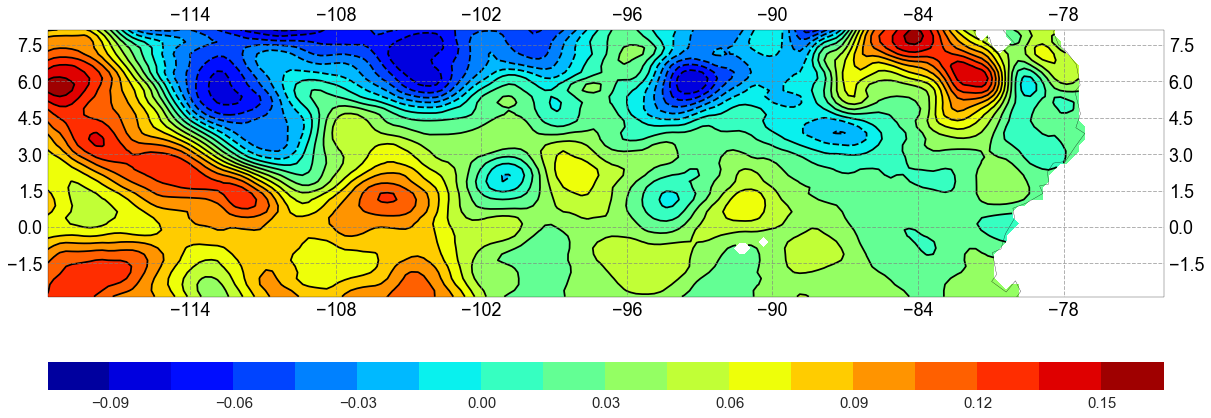

In [29]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,EOF,20,transform=ccrs.PlateCarree(),cmap="jet")
ct=ax.contour(x,y,EOF,20,transform=ccrs.PlateCarree(),colors='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.coastlines()
cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()
fig.savefig("Graficos\EOF_EOF.jpg",dpi=100,bbox_inches='tight')

In [61]:
# EOF multiplicada por los valores propios
matriz_EOF=np.zeros([len(U[:,0]),len(lat),len(lon)])
for i in range(len(U[:,0])):
    matriz_EOF[i,:,:]=EOF*U[i,0]

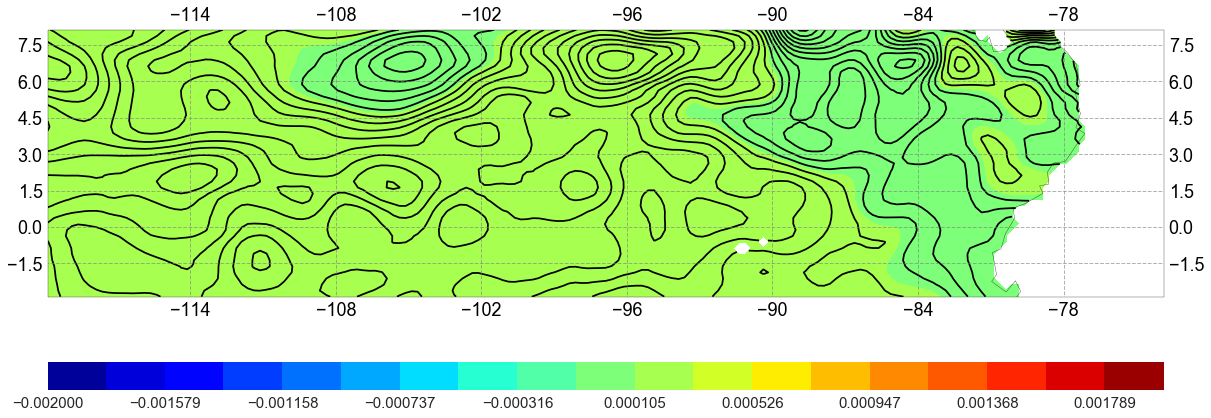

In [63]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,matriz_EOF[2000,:,:],20,transform=ccrs.PlateCarree(),cmap="jet",levels=np.linspace(-0.002,0.002,20))
ct=ax.contour(x,y,matriz_EOF[2000,:,:],20,transform=ccrs.PlateCarree(),colors='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.coastlines()
cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

## EOF con correlaciones

In [64]:
# EOF con correlaciones
U_corr,S_corr,Vh_corr=np.linalg.svd(A_corr)

In [21]:
U_corr.shape,S_corr.shape,Vh_corr.shape

((8924, 8924), (7444,), (7444, 7444))

### Modos de oscilación de EOF con correlación

<Figure size 576x396 with 0 Axes>

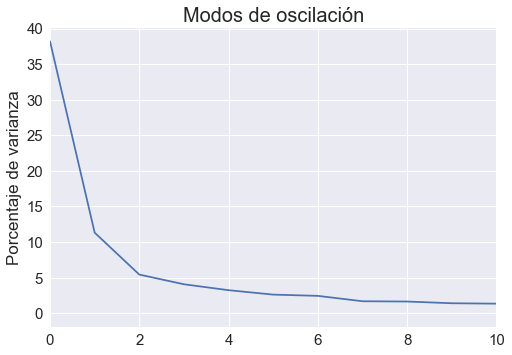

In [81]:
fig = plt.figure()
plt.figure()
plt.plot((S_corr/np.sum(S_corr))*100)
plt.xlim(0,10)
plt.title("Modos de oscilación", fontsize=20)
plt.ylabel("Porcentaje de varianza")
fig.savefig("Graficos\VAR-EOF_Var.jpg",dpi=100,bbox_inches='tight')

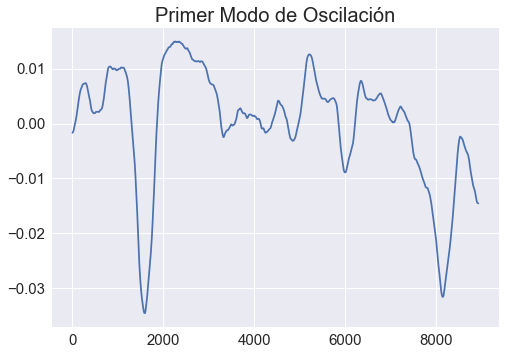

In [77]:
fig = fig=plt.figure()
plt.plot(U_corr[:,0])
plt.title('Primer Modo de Oscilación', fontsize=20)
fig.savefig("Graficos\VAR-EOF_PMO.jpg",dpi=100,bbox_inches='tight')

### Pintando EOF

In [69]:
iters=0
for i in range(len(verify)):
    if np.isnan(verify[i])==True:
        iters=iters
    if np.isnan(verify[i])==False:
        verify[i]==Vh_corr[0,iters]
        iters=iters+1

In [70]:
verify=np.copy(fila1_A)

In [71]:
EOF_corr=verify.reshape([len(lat),len(lon)])

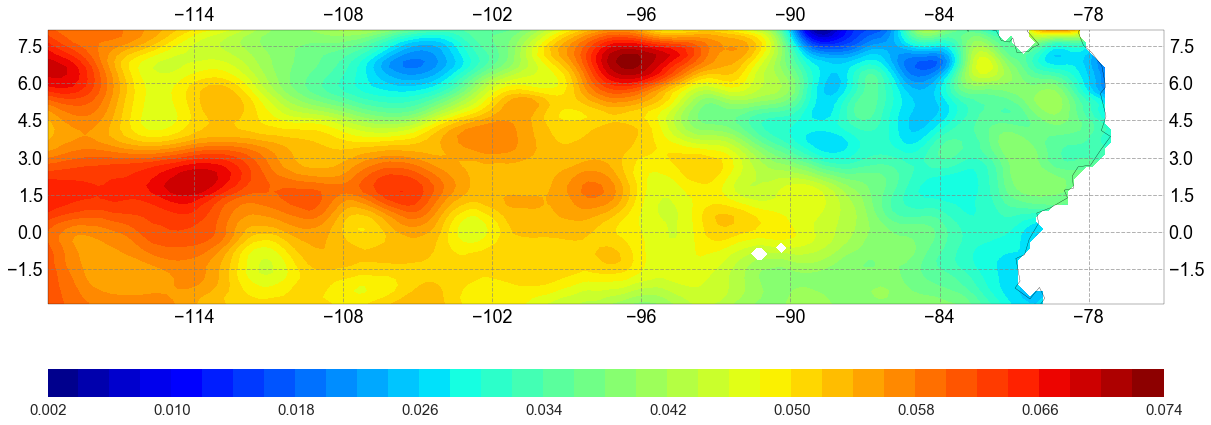

In [72]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,EOF_corr,40,transform=ccrs.PlateCarree(),cmap="jet")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.coastlines()
cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

fig.savefig("Graficos\VAR-EOF_EOF.jpg",dpi=100,bbox_inches='tight')